In [26]:
import json
from matplotlib import pyplot as plt
from pprint import pprint
import numpy as np
import pandas as pd
import os
import math
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

Preparing the data
===================

In [2]:

def getPVParams(track, mcps, mcvs):
    """ Given a track dict, the list of MCParticles and MCVertices 
    return the track PV position and ID (or None if not found or ambiguous)"""
    track_mcps = track['MCPs']
    # We ignore the tracks with no association to MCP or more than one
    if len(track_mcps) != 1:
        return None
    track_mcp = mcps[track_mcps[0]]
    track_pv_id = track_mcp['PV']
    track_pv = mcvs[track_pv_id]
    pos = track_pv['Pos']
    return pos[0], pos[1], pos[2], track_pv['key']



In [3]:

def getTrackFirstHitZ(track, hits):
    """ Returns the z of the first hit for the given track """
    hzs = [ hits[h]['z'] for h in track['LHCbIDs'] ]
    return min(hzs), max(hzs) 

 

In [4]:


def readData(filename, mycontainer):
    with open(filename) as mf:
        jdata = json.load(mf)
    #for key in jdata:
    #    print(key)
    VeloTracks  = jdata['VeloTracks']
    VeloHits  = jdata['VPClusters']
    mcps = jdata['MCParticles']
    mcvs = jdata['MCVertices']
    for  l in VeloTracks.values():
        #if l['isBackwards']:
        #    continue
        pvps = getPVParams(l, mcps, mcvs)
        if pvps != None:
            mycontainer.append(l['ClosestToBeam'] + list(pvps) + [len(l['LHCbIDs'])] 
                             + [ *getTrackFirstHitZ(l, VeloHits)]  + [ jdata['EventNumber']])


def load_data(filelist, prefix="data/train"):

    container = []
    for fn in filelist:
        readData(os.path.join(prefix, fn), container)

    df = pd.DataFrame.from_records(container, columns=['x', 'y', 'z', 'tx', 'ty', 'qp', 'pvx', 'pvy', 'pvz',
                                                    'pvid', 'LHCbIDCount', 'first_hit_Z', 'last_hit_Z', 'EvtNum'])
    container[:] = []
    return df
    
    


In [5]:

def getzerr(row):
    #print(row)
    return row['pvz'] - row['z']


In [6]:



prefix="data/train"
trainfiles = os.listdir(prefix)[:3000]
testfiles = os.listdir(prefix)[3000:4000]

df = load_data(trainfiles)
df_test = load_data(testfiles)

# Adding the error
df['zerr'] = df.apply(lambda row: getzerr(row), axis=1)
df_test['zerr'] = df_test.apply(lambda row: getzerr(row), axis=1)



Sanity checks
=============

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3f0a1e7b8>]],
      dtype=object)

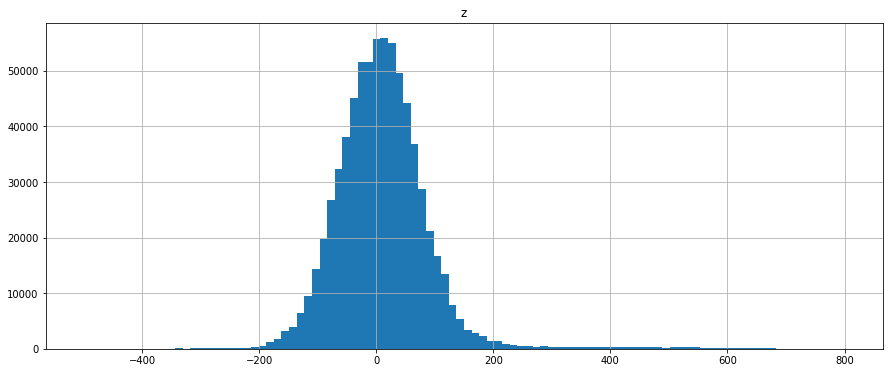

In [27]:
df.hist('z', bins=100, range = [-500, 800])

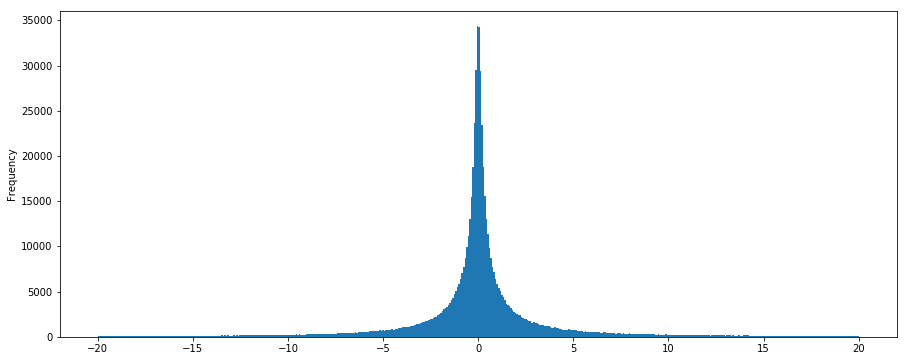

In [28]:
(df.z - df.pvz).plot(bins=500, kind='hist', range = [-20, 20], logy=False);

Adding the feature that defines the track "quality"
========================================

i.e. how useful it is to predict the PV position
We keep only the tracks for which the CTB z is less than 3mm from the MC PVz

In [9]:
# We decide that the cutoff is at 3mm
# Adding the error


def frompv(row):
    return (abs(row['zerr']) < 3.0)

df['valid'] = df.apply(lambda row: frompv(row), axis=1)
df_test['valid'] = df.apply(lambda row: frompv(row), axis=1)

In [10]:
df[df['valid'] == False]

,x,y,z,tx,ty,qp,pvx,pvy,pvz,pvid,LHCbIDCount,first_hit_Z,last_hit_Z,EvtNum,zerr,valid
0,0.001914,-0.006409,-22.309256,0.003983,-0.010017,0.0,0.0232,-0.0150,-13.2077,0,5,500.580994,750.580994,559230,9.101556,False
1,-0.038806,-0.050898,-19.987844,0.004090,-0.009627,0.0,0.0232,-0.0150,-13.2077,0,4,600.580994,750.580994,559230,6.780144,False
2,0.145686,0.198580,133.406631,0.028982,-0.016534,0.0,-0.0116,0.0082,89.5389,737,4,600.580994,749.419006,559230,-43.867731,False
4,1.617633,0.889093,37.046951,-0.033355,0.062746,0.0,0.0232,-0.0150,-13.2077,0,4,249.419006,499.419006,559230,-50.254651,False
7,-0.992756,0.002872,75.253731,-0.000304,-0.106804,0.0,-0.0116,0.0082,89.5389,737,4,261.919006,488.080994,559230,14.285169,False
8,1.876935,0.587155,42.906895,0.036616,-0.073036,0.0,-0.0122,0.0132,-53.2394,483,11,100.581001,486.919006,559230,-96.146295,False
12,2.313233,-1.173654,-27.497160,0.032765,0.074237,0.0,0.0232,-0.0150,-13.2077,0,5,225.580994,400.580994,559230,14.289460,False
14,-0.028335,0.058264,85.842728,-0.014528,0.099869,0.0,-0.0116,0.0082,89.5389,737,7,163.080994,399.419006,559230,3.696172,False
20,1.614120,3.316390,108.367393,-0.086970,0.046845,0.0,0.0232,-0.0150,-13.2077,0,7,163.080994,386.919006,559230,-121.575093,False
24,-0.029226,-0.027234,95.594833,0.014194,-0.006416,0.0,-0.0116,0.0082,89.5389,737,5,500.580994,750.580994,559230,-6.055933,False


Using a DT to predict the "valid" flag
=======================================

In [11]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
train_columns = ['x', 'y', 'z', 'tx', 'ty',
       'LHCbIDCount', 'first_hit_Z', 'last_hit_Z']
X = df.loc[:, train_columns]
y = df.loc[:, 'valid']


In [12]:

dt_clf = tree.DecisionTreeClassifier(random_state=0)
cross_val_score(dt_clf, X, y, cv=10, scoring='f1')

array([0.88482165, 0.88396207, 0.88209139, 0.88352056, 0.88273165,
       0.88104498, 0.88265892, 0.88178113, 0.88373559, 0.88533634])

In [13]:
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

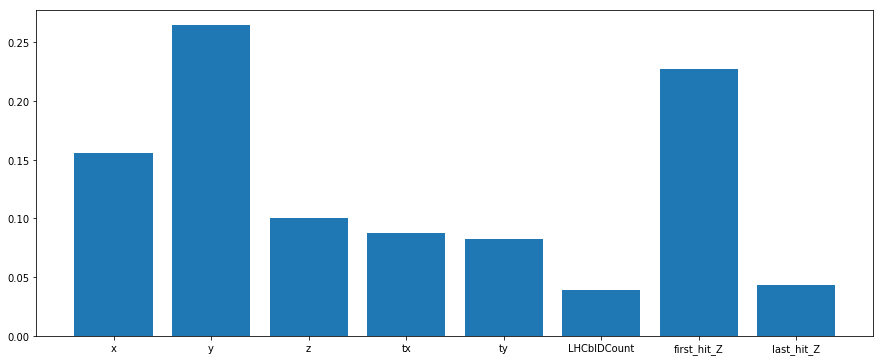

In [29]:
plt.bar(np.arange(len(dt_clf.feature_importances_)), dt_clf.feature_importances_);
plt.xticks(np.arange(len(dt_clf.feature_importances_)), X.columns);


In [16]:
from sklearn.metrics import recall_score, precision_score, f1_score

X_test = df_test.loc[:, train_columns]
y_test = df_test.loc[:, 'valid']

y_pred = dt_clf.predict(X_test)

print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))


0.7316267260269208
0.7285941901814991
0.7301073091718971


Conclusion on the first DT
-------------------------------------

The surprising effect of this training is that x and y play such a role. 
This may be due to the fact that in the simulation, the PVs are on the beamline, so x and y may be a sign that we have a bad fit.
Trying the fit again with less columns.

In [118]:
train_columns = ['z', 'tx', 'ty', 'first_hit_Z']
X2 = df.loc[:, train_columns].values

In [19]:

dt_clf2 = tree.DecisionTreeClassifier(random_state=0)
cross_val_score(dt_clf2, X, y, cv=10, scoring='f1')

array([0.88482165, 0.88396207, 0.88209139, 0.88352056, 0.88273165,
       0.88104498, 0.88265892, 0.88178113, 0.88373559, 0.88533634])

In [20]:

dt_clf2.fit(X2, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

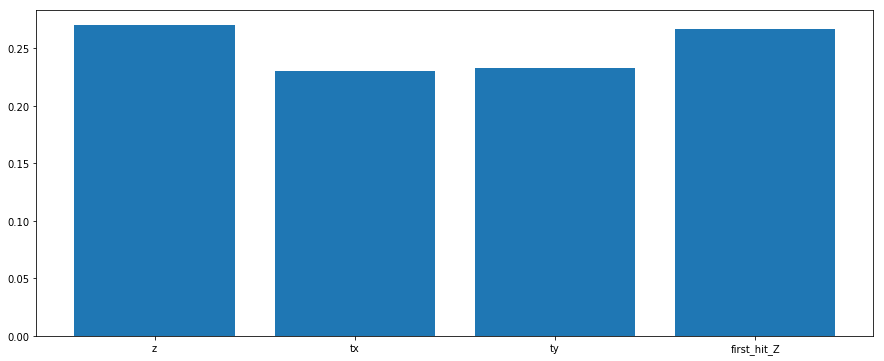

In [30]:
plt.bar(np.arange(len(dt_clf2.feature_importances_)), dt_clf2.feature_importances_);
plt.xticks(np.arange(len(dt_clf2.feature_importances_)), X2.columns);


In [22]:
from sklearn.metrics import recall_score, precision_score, f1_score

X2_test = df_test.loc[:, train_columns]
y2_test = df_test.loc[:, 'valid']

y2_pred = dt_clf2.predict(X2_test)

print(recall_score(y_test, y2_pred))
print(precision_score(y_test, y2_pred))
print(f1_score(y_test, y2_pred))

0.7249081191378851
0.7271886721135115
0.7260466047940176


In [23]:
from sklearn.externals import joblib
joblib.dump(dt_clf2, 'track_classifier.joblib') 

['track_classifier.joblib']

Trying a random forest classifier
===========================

/home/lben/.conda/envs/vertex_finding/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


after


/home/lben/.conda/envs/vertex_finding/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


after


/home/lben/.conda/envs/vertex_finding/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


after


/home/lben/.conda/envs/vertex_finding/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


after


/home/lben/.conda/envs/vertex_finding/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


after


/home/lben/.conda/envs/vertex_finding/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


after


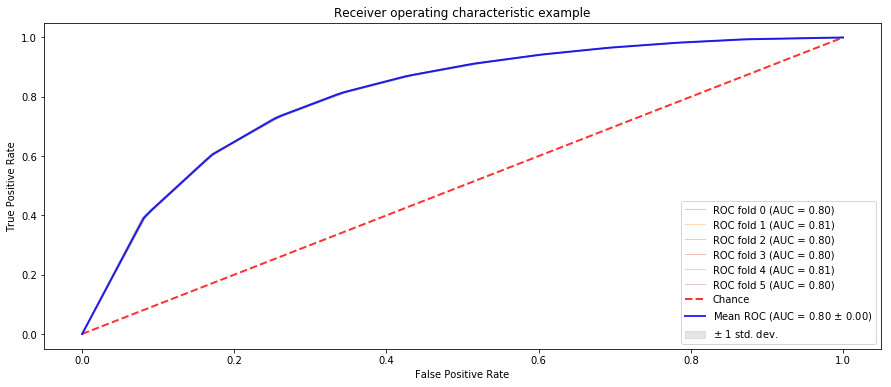

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
yl = LabelBinarizer().fit_transform(y)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X2, y):
    probas_ = classifier.fit(X2[train], yl[train]).predict_proba(X2[test])
    print("after")
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(yl[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



In [40]:
y2_pred = rfc.predict(X2_test)

print(recall_score(y_test, y2_pred))
print(precision_score(y_test, y2_pred))
print(f1_score(y_test, y2_pred))

0.7526173002678168
0.7277032935004372
0.739950643740133


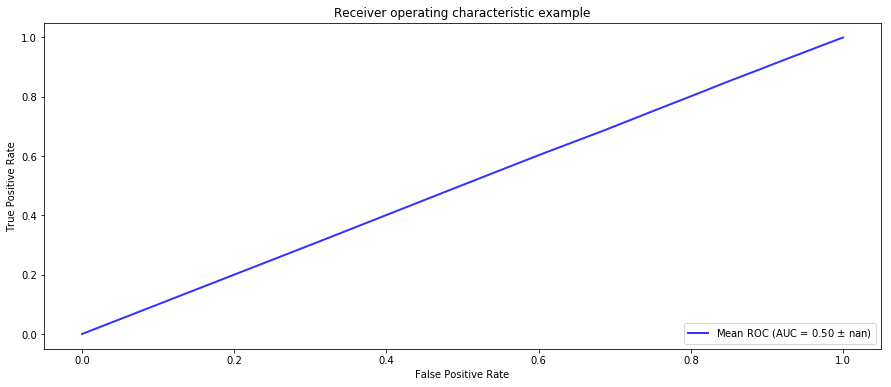

In [98]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from scipy import interp

y_scores = rfc.predict_proba(X2_test)
enc = LabelBinarizer()
y_test_enc =  enc.fit_transform(y_test)


# Compute ROC curve and area the curve
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fpr, tpr, thresholds = roc_curve(y_test_enc, y_scores[:, 1])
tprs.append(interp(mean_fpr, fpr, tpr))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)



plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
